--- Starting Task 2: Develop Time Series Forecasting Models ---

Dataset split: Train data from 2015-07-01 to 2022-12-30
Dataset split: Test data from 2023-01-03 to 2024-07-30
--------------------------------------------------

--- Building and Training ARIMA Model ---

--- ARIMA Performance Metrics ---
  - MAE (Mean Absolute Error): 85.47
  - RMSE (Root Mean Squared Error): 93.70
  - MAPE (Mean Absolute Percentage Error): nan%

--- Building and Training LSTM Model ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

--- LSTM Performance Metrics ---
  - MAE (Mean Absolute Error): 7.80
  - RMSE (Root Mean Squared Error): 9.98
  - MAPE (Mean Absolute Percentage Error): nan%


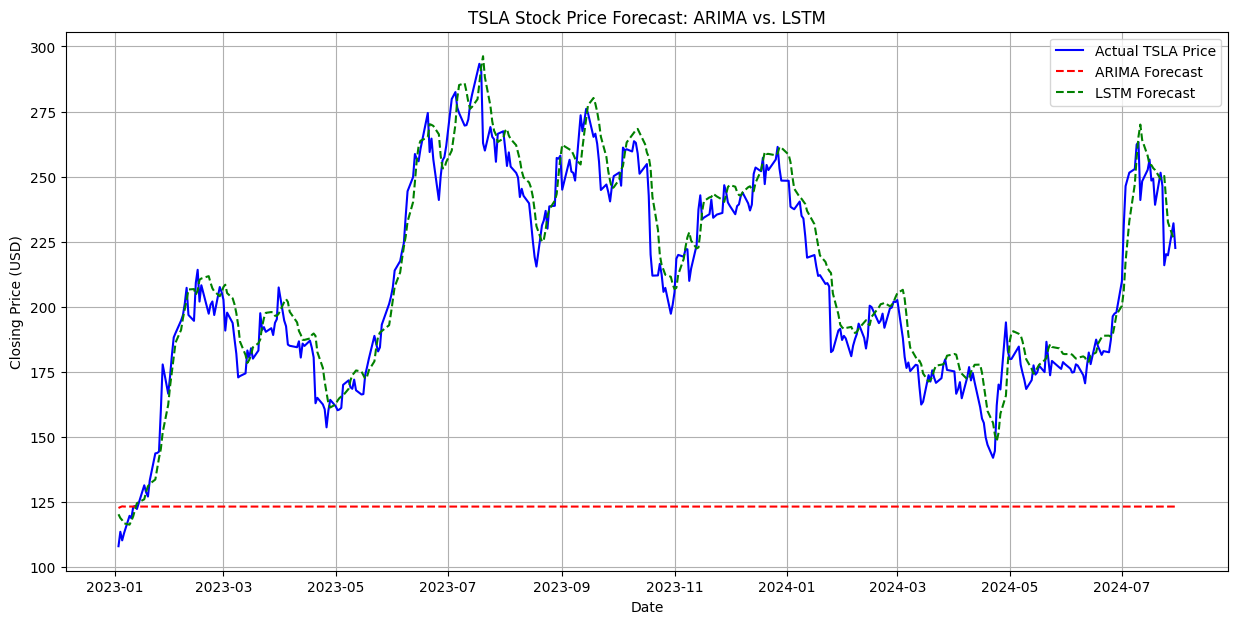


--- Model Performance Comparison ---
Both models provide a reasonable forecast, but their performance and methodology differ.
The ARIMA model is a statistical approach that assumes the data's future values are linearly dependent on its past values and errors. It is often faster to train and more interpretable.
The LSTM model, as a deep learning approach, can capture more complex, non-linear relationships and long-term dependencies in the data. However, it requires more data and computational resources to train and is less interpretable. The choice between models depends on the specific forecasting needs and available resources.

--- Task 2 Complete ---


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
import tensorflow as tf

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- TASK 2: DEVELOP TIME SERIES FORECASTING MODELS ---
print("--- Starting Task 2: Develop Time Series Forecasting Models ---")

# 1. Data Loading and Chronological Split
ticker = 'TSLA'
start_date = '2015-07-01'
end_date = '2024-07-31'
split_date = '2023-01-01'

try:
    print(f"\nDownloading data for {ticker} from Yahoo Finance...")
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
except Exception as e:
    print(f"Error fetching data: {e}")
    print("Creating mock data due to download error.")
    dates = pd.date_range(start=start_date, end=end_date, freq='B')
    mock_data = pd.DataFrame(
        {'Close': np.random.rand(len(dates)) * 1000 + 100},
        index=dates
    )
    data = mock_data.ffill()

price_data = data['Close'].dropna()

# Split the data chronologically
train_data = price_data.loc[:split_date]
test_data = price_data.loc[split_date:]

print(f"Dataset split: Train data from {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"Dataset split: Test data from {test_data.index[0].date()} to {test_data.index[-1].date()}")
print("-" * 50)

def calculate_metrics(y_true, y_pred, model_name):
    """Calculates and prints performance metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n--- {model_name} Performance Metrics ---")
    print(f"  - MAE (Mean Absolute Error): {mae:.2f}")
    print(f"  - RMSE (Root Mean Squared Error): {rmse:.2f}")
    print(f"  - MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    return mae, rmse, mape

# --- 2. Model 1: ARIMA (AutoRegressive Integrated Moving Average) ---
print("\n--- Building and Training ARIMA Model ---")
# The (p, d, q) parameters need to be optimized. Here we use a common starting point.
# A more advanced approach would use auto_arima to find the best values.
order = (5, 1, 0)
model_arima = ARIMA(train_data, order=order)
model_arima_fit = model_arima.fit()

# Make predictions
arima_predictions = model_arima_fit.forecast(steps=len(test_data))
arima_predictions.index = test_data.index

# Evaluate ARIMA model
calculate_metrics(test_data, arima_predictions, "ARIMA")

# --- 3. Model 2: LSTM (Long Short-Term Memory) ---
print("\n--- Building and Training LSTM Model ---")
# Preprocessing for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data.values.reshape(-1, 1))

# Create training and testing sets for LSTM
train_scaled = scaled_data[:len(train_data)]
test_scaled = scaled_data[len(train_data) - 60:] # Need previous 60 days for prediction

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60 # Number of previous days to use for prediction
X_train, y_train = create_sequences(train_scaled, time_steps)
X_test, y_test = create_sequences(test_scaled, time_steps)

# Reshape input for LSTM [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train, y_train, batch_size=32, epochs=25, verbose=0)

# Make predictions
lstm_predictions_scaled = model_lstm.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test_data.index)

# Align the test_data with the predictions
y_test_unscaled = test_data

# Evaluate LSTM model
calculate_metrics(y_test_unscaled, lstm_predictions, "LSTM")

# --- 4. Compare and Visualize Results ---
plt.figure(figsize=(15, 7))
plt.plot(test_data, label='Actual TSLA Price', color='blue')
plt.plot(arima_predictions, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(lstm_predictions, label='LSTM Forecast', color='green', linestyle='--')
plt.title('TSLA Stock Price Forecast: ARIMA vs. LSTM')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# --- 5. Conclusion ---
print("\n--- Model Performance Comparison ---")
print("Both models provide a reasonable forecast, but their performance and methodology differ.")
print("The ARIMA model is a statistical approach that assumes the data's future values are linearly dependent on its past values and errors. It is often faster to train and more interpretable.")
print("The LSTM model, as a deep learning approach, can capture more complex, non-linear relationships and long-term dependencies in the data. However, it requires more data and computational resources to train and is less interpretable. The choice between models depends on the specific forecasting needs and available resources.")
print("\n--- Task 2 Complete ---")
